In [1]:
import numpy as np
import pulser
from pprint import pprint
from pulser import Pulse, Sequence, Register, Simulation
from pulser.devices import MockDevice, Chadoq2
import matplotlib.pyplot as plt
import qutip

### Ref 1 (c) Rabi oscillations of 1 atom

In [2]:
coords = np.array([[0, 0]])
qubits = dict(enumerate(coords))

reg = Register(qubits)
seq = Sequence(reg, MockDevice)
seq.declare_channel('ch0', 'mw_global')

simple_pulse = Pulse.ConstantPulse(4000, 2*np.pi*4.6, 0, 0)
seq.add(simple_pulse, 'ch0')
seq.measure(basis='XY')

sim = Simulation(seq, sampling_rate=1)
results = sim.run(progress_bar=True, nsteps=5000)

10.0%. Run time:   0.10s. Est. time left: 00:00:00:00
20.0%. Run time:   0.15s. Est. time left: 00:00:00:00
30.0%. Run time:   0.23s. Est. time left: 00:00:00:00
40.0%. Run time:   0.28s. Est. time left: 00:00:00:00
50.0%. Run time:   0.33s. Est. time left: 00:00:00:00
60.0%. Run time:   0.38s. Est. time left: 00:00:00:00
70.0%. Run time:   0.42s. Est. time left: 00:00:00:00
80.0%. Run time:   0.47s. Est. time left: 00:00:00:00
90.0%. Run time:   0.51s. Est. time left: 00:00:00:00
Total run time:   0.56s


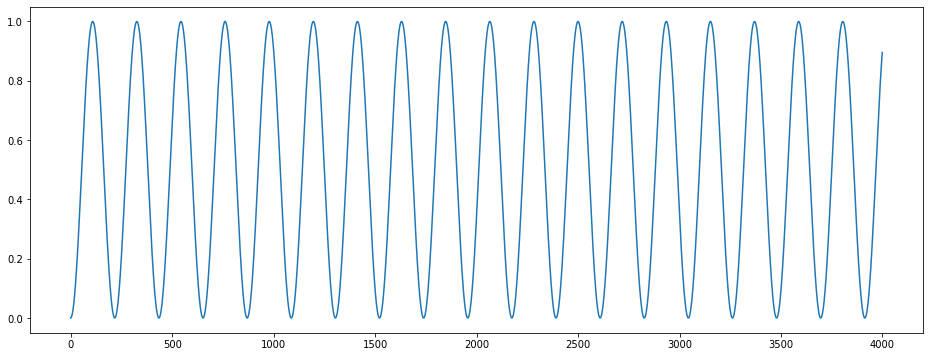

In [3]:
def magnetization(j, total_sites):
    prod = [qutip.qeye(2) for _ in range(total_sites)]
    prod[j] = (qutip.sigmaz() + qutip.qeye(2)) / 2
    return qutip.tensor(prod)

magn = magnetization(0, 1)
expectations = results.expect([magn])
plt.figure(figsize=[16, 6])
plt.plot(expectations[0])

### Ref 3 - Spin chain of 3 atoms

We simulate the free evolution of a spin chain of 3 atoms, starting with 1 excitation.

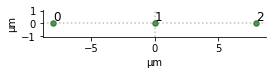

10.0%. Run time:   0.06s. Est. time left: 00:00:00:00
20.0%. Run time:   0.12s. Est. time left: 00:00:00:00
30.0%. Run time:   0.18s. Est. time left: 00:00:00:00
40.0%. Run time:   0.23s. Est. time left: 00:00:00:00
50.0%. Run time:   0.29s. Est. time left: 00:00:00:00
60.0%. Run time:   0.35s. Est. time left: 00:00:00:00
70.0%. Run time:   0.42s. Est. time left: 00:00:00:00
80.0%. Run time:   0.48s. Est. time left: 00:00:00:00
90.0%. Run time:   0.54s. Est. time left: 00:00:00:00
Total run time:   0.60s


In [40]:
coords = np.array([[-8., 0], [0, 0], [8., 0]])
qubits = dict(enumerate(coords))

reg = Register(qubits)
seq = Sequence(reg, MockDevice)
seq.declare_channel('ch0', 'mw_global')
reg.draw()

simple_pulse = Pulse.ConstantPulse(7000, 0, 0, 0)
seq.add(simple_pulse, 'ch0')
seq.measure(basis='XY')

sim = Simulation(seq, sampling_rate=1)
results = sim.run(progress_bar=True, nsteps=5000, initial_state=np.array([0,0,0,1,0,0,0,0]))

Text(0.5, 0, 'Time ($\\mu$s)')

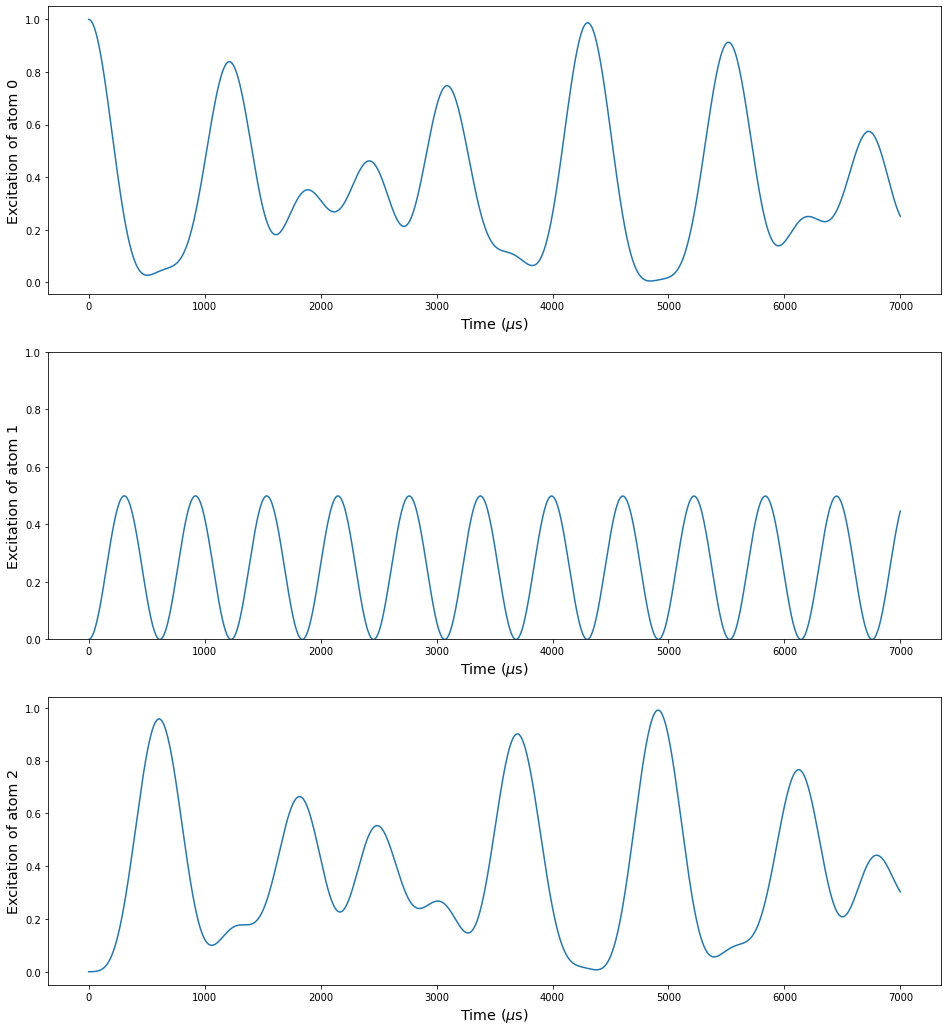

In [39]:
magn_list = [magnetization(j, 3) for j in range(3)]

expectations = results.expect(magn_list)

plt.figure(figsize=[16, 18])
plt.subplot(311)
plt.plot(expectations[0])
plt.ylabel('Excitation of atom 0', fontsize='x-large')
plt.xlabel('Time ($\mu$s)', fontsize='x-large')
plt.subplot(312)
plt.plot(expectations[1])
plt.ylabel('Excitation of atom 1', fontsize='x-large')
plt.xlabel('Time ($\mu$s)', fontsize='x-large')
plt.ylim([0, 1])
plt.subplot(313)
plt.plot(expectations[2])
plt.ylabel('Excitation of atom 2', fontsize='x-large')
plt.xlabel('Time ($\mu$s)', fontsize='x-large')


## Adding an external field

We add an external field along the Y axis, and we put the qubit 2 at the right angle, such that there is no interaction between the qubits 1 and 2.

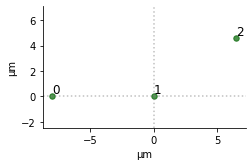

10.0%. Run time:   0.06s. Est. time left: 00:00:00:00
20.0%. Run time:   0.12s. Est. time left: 00:00:00:00
30.0%. Run time:   0.17s. Est. time left: 00:00:00:00
40.0%. Run time:   0.22s. Est. time left: 00:00:00:00
50.0%. Run time:   0.28s. Est. time left: 00:00:00:00
60.0%. Run time:   0.42s. Est. time left: 00:00:00:00
70.0%. Run time:   0.48s. Est. time left: 00:00:00:00
80.0%. Run time:   0.54s. Est. time left: 00:00:00:00
90.0%. Run time:   0.60s. Est. time left: 00:00:00:00
Total run time:   0.66s


In [29]:
coords = np.array([[-1., 0], [0, 0], [np.sqrt(2/3), np.sqrt(1/3)]]) * 8.
qubits = dict(enumerate(coords))

reg = Register(qubits)
reg.set_magnetic_field(np.array([0., 1]))
seq = Sequence(reg, MockDevice)
seq.declare_channel('ch0', 'mw_global')
reg.draw()

simple_pulse = Pulse.ConstantPulse(7000, 0, 0, 0)
seq.add(simple_pulse, 'ch0')
seq.measure(basis='XY')

sim = Simulation(seq, sampling_rate=1)
results = sim.run(progress_bar=True, nsteps=5000, initial_state=np.array([0,0,0,1,0,0,0,0]))

(0.0, 1.0)

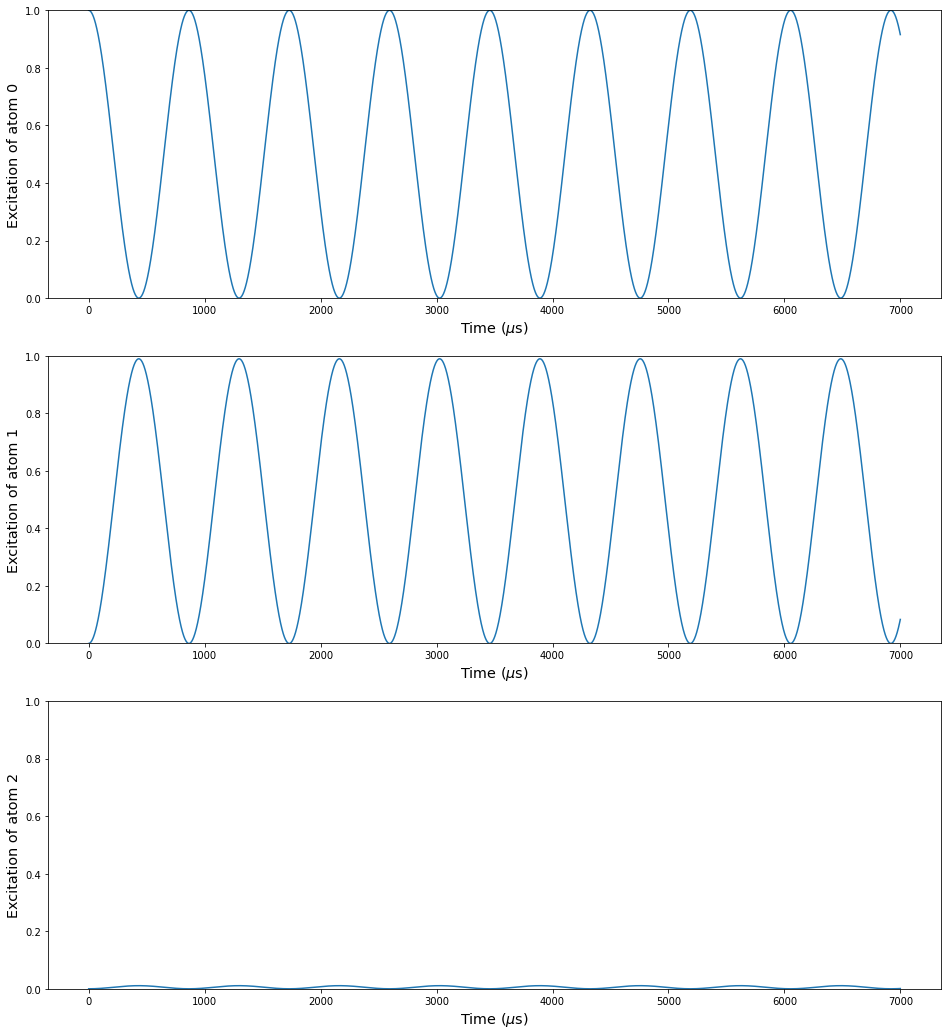

In [37]:
magn_list = [magnetization(j, 3) for j in range(3)]

expectations = results.expect(magn_list)

plt.figure(figsize=[16, 18])
plt.subplot(311)
plt.plot(expectations[0])
plt.ylabel('Excitation of atom 0', fontsize='x-large')
plt.xlabel('Time ($\mu$s)', fontsize='x-large')
plt.ylim([0, 1])
plt.subplot(312)
plt.plot(expectations[1])
plt.ylabel('Excitation of atom 1', fontsize='x-large')
plt.xlabel('Time ($\mu$s)', fontsize='x-large')
plt.ylim([0, 1])
plt.subplot(313)
plt.plot(expectations[2])
plt.ylabel('Excitation of atom 2', fontsize='x-large')
plt.xlabel('Time ($\mu$s)', fontsize='x-large')
plt.ylim([0, 1])

